In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/augmented-alzheimer-mri-dataset-with-93-5/Osteoporosis_Model_binary.h5
/kaggle/input/augmented-alzheimer-mri-dataset-with-93-5/__results__.html
/kaggle/input/augmented-alzheimer-mri-dataset-with-93-5/__notebook__.ipynb
/kaggle/input/augmented-alzheimer-mri-dataset-with-93-5/__output__.json
/kaggle/input/augmented-alzheimer-mri-dataset-with-93-5/custom.css
/kaggle/input/augmented-alzheimer-mri-dataset-with-93-5/__results___files/__results___15_0.png
/kaggle/input/augmented-alzheimer-mri-dataset-with-93-5/__results___files/__results___9_0.png
/kaggle/input/augmented-alzheimer-mri-dataset-with-93-5/__results___files/__results___16_0.png
/kaggle/input/augmented-alzheimer-mri-dataset-with-93-5/__results___files/__results___18_0.png
/kaggle/input/augmented-alzheimer-mri-dataset/OriginalDataset/ModerateDemented/moderateDem40.jpg
/kaggle/input/augmented-alzheimer-mri-dataset/OriginalDataset/ModerateDemented/moderateDem26.jpg
/kaggle/input/augmented-alzheimer-mri-dataset/OriginalD

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [7]:
# augmented dataset 
dataset_path = "/kaggle/input/augmented-alzheimer-mri-dataset/AugmentedAlzheimerDataset"

data = []

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    
    if os.path.isdir(category_path):
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            
            data.append({"image_path": image_path, "category": category})

df = pd.DataFrame(data)

output_csv = "dataset.csv"
df.to_csv(output_csv, index=False)

print(f"CSV file saved as {output_csv}")
df.head()

CSV file saved as dataset.csv


In [3]:
# original dataset 
dataset_path = "/kaggle/input/augmented-alzheimer-mri-dataset/OriginalDataset"

data = []

for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    
    if os.path.isdir(category_path):
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            
            data.append({"image_path": image_path, "category": category})

df_o = pd.DataFrame(data)

output_csv = "dataset_o.csv"
df_o.to_csv(output_csv, index=False)

print(f"CSV file saved as {output_csv}")
df_o.head()

CSV file saved as dataset_o.csv


In [43]:
graph

,category,image_path
0,MildDemented,8960
1,ModerateDemented,6464
2,NonDemented,9600
3,VeryMildDemented,8960


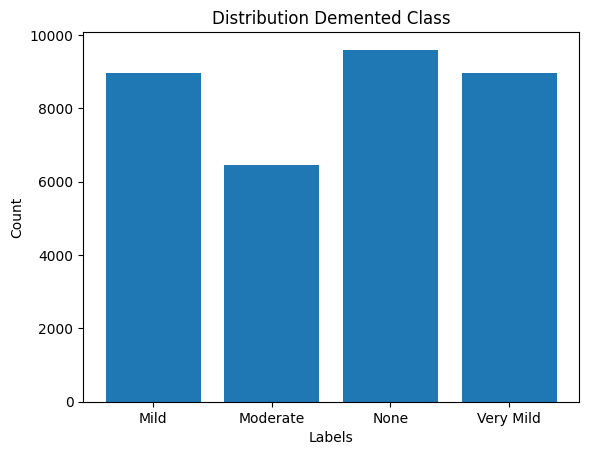

In [48]:
graph=df.groupby(["category"]).agg("count").reset_index()
# Counting the occurrences of each class label
category_counts = graph["category"].value_counts()
plt.bar( ['Mild','Moderate','None','Very Mild'],  graph["image_path"])
plt.xticks(['Mild','Moderate','None','Very Mild'])
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution Augmented dataset of Demented Class')
plt.show()

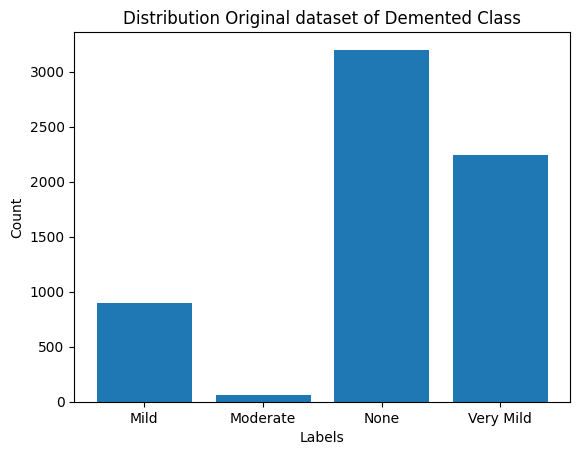

,category,image_path
0,MildDemented,896
1,ModerateDemented,64
2,NonDemented,3200
3,VeryMildDemented,2240


In [50]:
graph_o=df_o.groupby(["category"]).agg("count").reset_index()
# Counting the occurrences of each class label
category_counts = graph["category"].value_counts()
plt.bar( ['Mild','Moderate','None','Very Mild'],  graph["image_path"])
plt.xticks(['Mild','Moderate','None','Very Mild'])
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution Original dataset of Demented Class')
plt.show()
graph_o